## Convolutional Neural Network

Convolutional Neural Network는 입력 데이터의 local space 구조를 이용할 수 있는 순전파 신경망이다. 지정가 주순 호가창 깊이의 히스토리와 같은 고차원 시계열의 평탄화를 위해 순전파 구조에서는 매우 많은 수의 가중치가 필요하다.CNN은 데이터 국지성을 이용해 네트워크 크기를 줄이려고 시도한다.

비선형 함수에 이어 여러 연속 합성곱을 가진 Deep CNN은 이미지 처리에서 큰 성공을 거뒀다. Convolution을 데이터의 특정 패턴을 선택하게 설계된 공간 필터로 볼 수 있다. 따라서 이미지의 평활화(smoothing), 선명화(sharpening), 가장자리 감지(edge detection)와 같은 이미지 처리에 합성곱이 자주 사용된다. 물론 금융 모델링에서 우리는 일반적으로 지정가 주문 호가창의 깊이(market depth) 또는 파생상품의 내재 변동성 표면과 같은 상이한 공간 구조를 가지고 있다. 그러나 CNN은 시계열 분석에서도 입지를 굳혔다.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

data = yf.download(
    '^GSPC',
    start = '2000-01-01',
    progress = False
)

### 1. Exponential Moving Average Smoothing

시계열 분석 및 신호 처리에서 일반적인 기법은 시계열 필터링이다. 우리는 이미 지수 평활화를 가중 이동 평균(weighted moving average)이라고 알려진 평활화 클래스의 특별한 사례로 봤다. WMA smoothing이라고 알려진 평활화 클래스의 특별한 사례로 봤다. WMA smoothing은 다음 형태를 취한다. 

$$\tilde{x}_t = \frac{1}{\sum_{i \in I} w_i}\sum_{i \in I}w_i x_{t-i}$$

여기서 $\hat{x}_t$ 는 시계열의 국지적 평균이다. 가중치는 span $\vert ~ \mathcal{I} ~ \vert$ 내의 특정 관측 $x_{t-i}$를 강조하거나 또는 강조하지 않고자 설정된다. 잘 알려진 평활화법의 예는 다음과 같은 Hanning Smoother $h(3)$을 포함한다.

$$\tilde{x}_t = \frac{x_{t-1}+2x_t + x_{t+1}}{4}$$

이와 같은 평활법은 시계열의 잡음을 줄이는 효과를 갖는다. 이동 평균 필터는 일반적으로 샘플된 데이터 배열을 조절하는 데 사용되는 Simple low pass Finite Impulse Response filter이다. 이는 한번에 입력으로부터 $\vert ~ \mathcal{I} ~ \vert$ 샘플을 취하고 이들의 가중 평균을 취해 단일 출력 포인트를 생성한다. 필터의 길이가 증가할수록 출력의 평활성은 증가하는 반면, 데이터의 sharpeness는 부드러워진다.

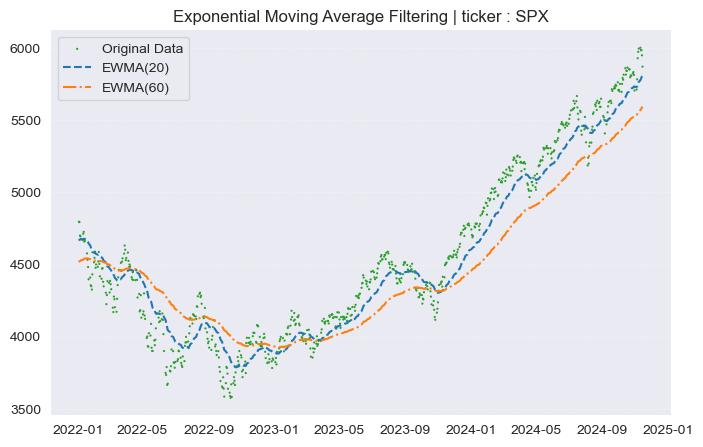

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    data.loc['2022':, 'Close'].index, 
    data.loc['2022':, 'Close'],
    label = 'Original Data',
    marker = '.',
    edgecolor = 'none',
    s = 10,
    color = 'tab:green'
)
ax.plot(data['Close'].ewm(20).mean().loc['2022':], label = 'EWMA(20)', ls = '--')
ax.plot(data['Close'].ewm(60).mean().loc['2022':], label = 'EWMA(60)', ls = '-.')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Exponential Moving Average Filtering | ticker : SPX')
plt.show()

이동평균 필터는 실제로 단순한 필터 커널을 사용하는 합성곱이다. 더 일반적으로 우리는 일변량 시계열 예측 문제를 다음과 같이 필터를 가진 합성곱으로 표현할 수 있다. 첫째, 이산 합성곱으로 다음과 같은 $x_i$와 $x_j$의 관계를 얻는다.

$$x_{t-i} = \sum_{j=0}^{t-1} \delta_{ij}x_{t-j}, ~~ i \in \{0, \dots, t-1\}$$

여기서 $\delta$는 크로네커 델터이다. kernel filtered time series는 다음과 같은 합성곱이다.

$$\tilde{x}_{t-i} = \sum_{j \in J} K_{j+k+1}x_{t-i-j}, i \in \{k+1, \dots, p-k\}$$

여기서 $J := \{-k, \dots, k\}$이므로 필터의 span은 $|J| = 2k+1$이다. $k$는 작은 정수이고, 커널은 $K$이다. 단순성을 위해 sequence의 끝은 필터링되지 않으나 표기의 편의상 $i \in \{1, \dots, k, p-k+1, \dots, p\}$에 대해 $\tilde{x}_{t-i} = x_{t-i}$로 설정한다. 그러면 $\text{AR}(p)$모형은 다음과 같이 된다.

$$
\begin{align}
\hat{x}_t = & \mu + \sum_{i=1}^p \phi_i \tilde{x}_{t-i} \\
= & \mu + \left( \phi_1 L + \phi_2 L^2 + \cdots + \phi_p L^p\right)\left[ \tilde{x}_t \right] \\ 
= & \mu + \left[ L, L^2, \dots, L^p \right] \phi \left[ \tilde{x}_t \right]
\end{align}
$$

여기서 계수는 $\phi := \left[\phi_i, \dots, \phi_p \right]$이다. 관측 데이터 $\{ \mathcal{X}_s \}_{s=1}^t$의 마지막 $k$값을 필터링하지 않으므로 선견 편향이 없다는 것을 유의하자. 다음과 같이 순전파 출력층과 1개 유닛의 비활성 은닉층으로 구성된 최초의 1D CNN을 표현한다.

$$\hat{x}_t = W_y z_t + b_y, z_t = \left[ \tilde{x}_{t-1}, \dots, \tilde{x}_{t-p} \right]^T, W_y = \phi^T, b_y = \mu$$

여기서 $\tilde{x}_{t-i}$는 $2k+1$개의 가중치로 구성된 하나의 커널을 가진 길이 $p$의 입력 시퀀스의 합성곱으로부터의 $i$번째 출력이다. 이들 가중치는 시간에 대해 고정이며, 따라서 CNN은 저상성 시계열로부터의 예측에만 맞는다. 또한 $\text{RNN}$에 비해 가중치 행렬 $W_y$의 크기가 모델의 time lag 수에 따라서 증가한다는 것을 유의하자.

time lag $p$와 $H$개의 activation hidden kernel을 가진 일변량 CNN 예측 변수는 다음과 같다.

$$
\begin{align}
\hat{x}_t = & W_y \text{vec}(z_t) + b_y \\
[z_t]_{i,m} = & \sigma \left( \sum_{j \in J} K_{m,j+k+1}x_{t-i-j} + [b_h]_m\right) \\
= & \sigma \left( K \circ x_t + b_h\right)
\end{align}
$$

여기서 $m \in \{1, \dots, H\}$는 커널의 인덱스를 표기하고 커널 행렬은 $K \in \mathbb{R}^H$이며 출력 행렬은 $W_y \in \mathbb{R}^{1 \times pH}$이다.

In [7]:
from FinancialDeepLearning.dimension_reduction.convolution import ConvolutionalNeuralNetwork

cnn = ConvolutionalNeuralNetwork(data['Close'].pct_change().dropna())

In [8]:
window_size = 20
nb_input_series = 1 # univariate time series
nb_filter = 16 # number of filters
filter_length = 5
nb_outputs = 1

cnn.fit(
    window = window_size,
    nb_input_series = nb_input_series,
    nb_filter = nb_filter,
    kernel_size = filter_length,
    nb_outputs = nb_outputs,
    num_epochs = 50,
    batch_size = 32,
    learning_rate = 0.001
)

100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


In [9]:
cnn_smoothed = cnn.fittedvalues()

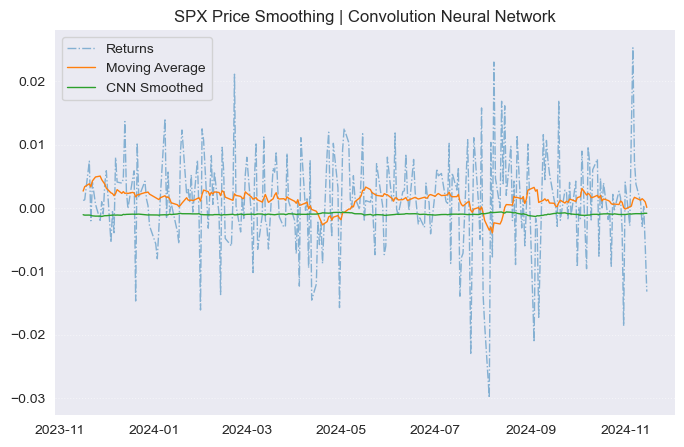

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data.index[-252:], data['Close'].pct_change()[-252:], 
    label = 'Returns',
    lw = 1,
    ls = '-.',
    alpha = 0.5
)
ax.plot(
    data.index[-252:], 
    data['Close'].pct_change().rolling(20).mean()[-252:], 
    label = 'Moving Average',
    lw = 1
)
ax.plot(
    data.index[-252:], cnn_smoothed[-252:], 
    label = 'CNN Smoothed', 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('SPX Price Smoothing | Convolution Neural Network')
plt.show()

#### Shrinkage

$W_y$의 크기는 lag 수와 커널 수 모두에 따라 증가하므로 추가 계층으로 가중치의 차원을 줄여 과적합을 피하는 것이 바람직할 수 있다. 나중에 이 개념을 다시 살피겠지만 auto-shrinkage 또는 dropout의 대안으로 볼 수 있다.

In [11]:
shrinkage_dim = 16  # Shrinkage layer output dimension

dropout_model = ConvolutionalNeuralNetwork(data['Close'].pct_change().dropna())

In [12]:
window_size = 20
nb_input_series = 1 # univariate time series
nb_filter = 16 # number of filters
filter_length = 5
nb_outputs = 1

dropout_model.fit(
    window = window_size,
    nb_input_series = nb_input_series,
    nb_filter = nb_filter,
    kernel_size = filter_length,
    nb_outputs = nb_outputs,
    num_epochs = 50,
    batch_size = 32,
    learning_rate = 0.001,
    use_dropout = True,
    dropout_rate = 0.1
)

100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


In [13]:
dropout_smoothed = dropout_model.fittedvalues()

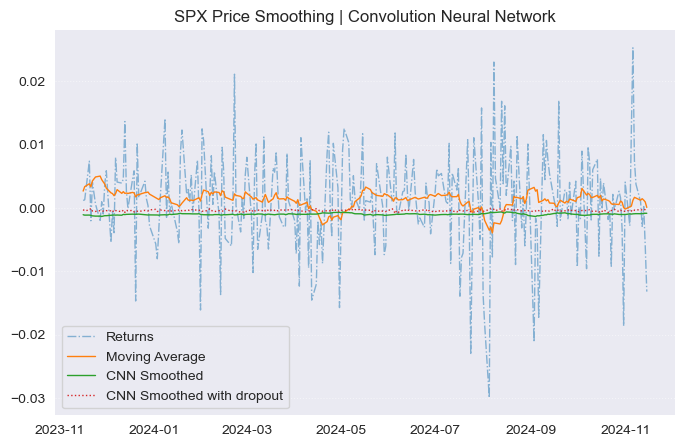

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data.index[-252:], data['Close'].pct_change()[-252:], 
    label = 'Returns',
    lw = 1,
    ls = '-.',
    alpha = 0.5
)
ax.plot(
    data.index[-252:], 
    data['Close'].pct_change().rolling(20).mean()[-252:], 
    label = 'Moving Average',
    lw = 1
)
ax.plot(
    data.index[-252:], cnn_smoothed[-252:], 
    label = 'CNN Smoothed', 
    lw = 1
)
ax.plot(
    data.index[-252:], dropout_smoothed[-252:], 
    label = 'CNN Smoothed with dropout', 
    lw = 1,
    ls = ':'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('SPX Price Smoothing | Convolution Neural Network')
plt.show()

### 비순차적 모델

합성곱 신경망은 순차적 모델에 국한되지 않는다. 예를 들어 과거 시차를 비균등 샘플로 추출하여 $I = \{2^i\}_{i=1}^p$이며 이때 모델의 최대 시차는 $2p$이다. 이러한 비순차적 모델은 모든 중간 시차를 포착하지 않고 최대 시차를 허용한다. 또한 '팽창 합성곱'절에서 비순차적 모델을 다시 살펴볼 것이다.

### Stationarity

1개의 커널과 activation function이 없는 CNN 예측 변수는 표준 형태로 표현될 수 있다. 

$$
\begin{align}
\hat{x}_t =& \mu + \left( 1 - \Phi(L)\right) \left[ Kx_t\right] \\
=& \mu + K\left(1 - \Phi(L)\right)[x_t] \\
=& \mu + \left( \tilde{\phi}_1 L + \dots + \tilde{\phi}_p L^p \right) [x_t] \\
:=& \mu + \left( 1 - \tilde{\Phi}(L)\right)[x_t]
\end{align}
$$

여기서 $x_t$에서 $\Phi(L)$의 선형성에 의해 합성곱은 교환할 수 있으므로 $\tilde{\phi}:= K\phi$로 표현할 수 있다. 다음의 특성 방정식의 근을 찾을 때를 가정해보자.

$$\tilde{\Phi}(z) = 0$$

모든 근이 복소수 평면 내의 단위 원 밖에 존재하면, 즉 $|\lambda_i| > 1, i \in \{1, \dots, p\}$면 CNN이 강정상성이고 ergodic이다. 이전과 같이 동반 행렬의 고유값을 계산해 근을 찾을 수 있다. $\Phi(L)^{-1}$이 잡음 프로세스 $\{\varepsilon_s\}_{s=1}^t$의 발산 시퀀스를 형성하면 모델은 안정적이다.

### 2D Convolution

2D Convolution은 input matrix $X \in \mathbb{R}^{m \times K}$에 대해 작은 kernel matrix(즉, 필터) $K \in \mathbb{R}^{2k+1 \times 2k+1}$를 적용해 필터링된 이미지$Y \in \mathbb{R}^{m-2k \times n-2k}$를 얻는 것과 관련 있다. CNN 맥락에서 필터링된 이미지의 원소는 feature map 값으로 불리며, 다음 공식에 따라 계산된다.

$$y_{i,j} = \left[K \times X \right]_{i,j} = \sum_{p,q = -k}^k K_{k+1+p, k+1+q}x_{i+p+1, j+q+1}, i \in \{1, \dots, m\}, j\in \{1, \dots, n\}$$

예를 들어, $3 \times 3$ 커널을 가진 $4 \times 4$ 이미지에 대해 합성곱을 수행하면 $2 \times 2$ feature map을 얻는다. 이는 필터를 이미지 내에 놓을 때 단지 4개의 유일한 포지션이 있기 때문이다. 합성곱 신경망은 이미지 처리를 위해 설계됐으므로 pixel의 컬러 값을 $c$ 컬러 채널로 표현하는 것이 일반적이다. 예를 들어 RGB 값은 3개의 채널로 표현된다. $m \times n \times c$ 입력 텐서와 출력 $m \times x \times H$에 대한 합성곱층의 일반적 형태는 다음과 같다.

$$\theta : \mathbb{R}^{m \times n \times c} \rightarrow \mathbb{R}^{m \times n \times H}$$

$f$가 다음과 같다고 해보자.

$$f = \begin{pmatrix} f_1 \\ \vdots \\ f_c\end{pmatrix}$$

여기서 $K \in \mathbb{R}^{[(2k+1) \times (2k+1)] \times H \times c}$이고 $\mathbf{b} := \mathbf{1}_{m \times n} \otimes b$로 정의될 때 $b \in \mathbb{R}^{m \times n \times H}$이며, $1_{m \times n}$은 모든 원소가 1인 $m \times n$ 행렬이다. 원소 형태로 연산은 다음과 같다.

$$\left[ \theta(f)\right]_j = \sum_{i=1}^c [K]_{i,j} \times [f]_i + \mathbf{b}_j, \qquad j \in \left\{1, \dots, H\right\}$$

여기서 $[\cdot]_{i,j}$는 텐서의 $i$번째 3번째 성분과 $j$번째 4번째 성분에 인덱스를 매김으로써 4차원 텐서를 2차원 텐서로 축소하고, 임의의 $g \in \mathbb{R}^{m \times n}$와 $H \in \mathbb{R}^{(2k + 1) \times (2k+1)}$에 대해 다음이 성립한다.

$$\left[ H \times g\right]_{i,j} = \sum_{p,q = -k}^k H_{k+1+p, k+1+q}g_{i+p, j+q}, \qquad i \in \{1, \dots, m\}, j \in \{1, \dots, n\}$$

완전 결합 순전파 구조와 유사하게 계층의 가중치는 커널 텐서 $K$에 의해 주어지고 bias $b$는 $H$-vector이다. 계층은 준어파인 변환 대신 활성화된 합성곱 $\sigma\left(\mathbf{\theta}(f)\right)$에 의해 주어진다.

게다가 활성화된 합성곱 계층 안의 모든 뉴런이 서로 연결돼 있지 않다는 것을 주의하자. 실제로 $2k + 1 \times 2k + 1$ 정방 행렬 내의 입력에 해당하는 뉴런은 단지 동일한 출력 뉴런에 연결된다. 따라서 필터 크기는 각 출력의 수용영역(receptive field)을 조절한다. 따라서 어떤 뉴런은 동일한 가중치를 공유한다. 이들 속성은 fully connected feedforward network 구조보다 더 적은 수의 학습할 파라미터를 생성한다.

padding은 이미지 $f$의 크기를 확장해 필터링된 이미지가 원 이미지와 동일한 차원을 가지게 하는 데 필요하다. 구체적으로 padding은 $(i+p, j+q)$가 $\{1, \dots, m\}$ 또는 $\{1, \dots, n\}$을 벗어날 때 $f_{i+p, j+q}$를 선택하는 방법을 의미한다. 다음과 같은 식이 있을 때

$$i + p \notin \{1, \dots, m\} \text{~~or~~} j+q \notin\{1, \dots, n\}$$

다음 3가지 선택이 흔히 사용된다.

$$
f_{i+p, j+q}=
\begin{cases}
0, & \qquad \text{zero padding} \\
f_{(i+p)(\mod m),(s+q)(\mod n)}, & \qquad  \text{periodic padding} \\
f_{|i-1+p|, |j-1+q|}, & \qquad  \text{reflected padding}
\end{cases}
$$

여기서 $d(\mod m) \in \{1,\dots,m\}$은 $d$를 $m$으로 나눴을 때의 나머지를 의미한다. 식 $\left[ H \times g\right]_{i,j} = \sum_{p,q = -k}^k H_{k+1+p, k+1+q}g_{i+p, j+q}, \qquad i \in \{1, \dots, m\}, j \in \{1, \dots, n\}$안의 연산은 stride 1의 합성곱이라 불린다. 비공식적으로 말하면 이미지 영역을 1씩 증가해 미끄러져 나아감으로써 합성곱을 수행한다. CNN에서의 일반적 선택은 $s=2$를 취하는 것이다. $s \geq 1$이 주어졌을 때 $f \in \mathbb{R}^{m \times n}$에 대한 stride $s$의 합성곱은 다음과 같이 정의된다.

$$\left[ K *_s f\right]_{i,j} = \sum_{p,q = -k}^k K_{p,q}f_{s(i-1)+1+p,s(j-1)+1+q}, i \in \left\{1, \dots, \lceil \frac{m}{s} \rceil\right\}, \qquad j \in \left\{1, \dots, \lceil \frac{n}{s} \rceil\right\}$$

여기서 $\lceil \frac{m}{s} \rceil$는 $\frac{m}{s}$보다 큰 것중 가장 작은 정수를 표기한다.

In [15]:
data = yf.download(
    ['AAPL','NVDA','GE','XOM','MSFT','AMZN','JPM','NFLX','PLD','V','LLY','HD'],
    start = '2015-01-01',
    progress = False
)['Close']

In [16]:
returns = data.pct_change().dropna()

In [17]:
cnn_2d = ConvolutionalNeuralNetwork(returns)

In [18]:
in_channels = 1 
nb_filter = 3
kernel_size = (3, 3)  
nb_outputs = 1 
window_size = 20

cnn_2d.fit(
    window = window_size,
    nb_input_series = in_channels,
    nb_filter = nb_filter,
    kernel_size = kernel_size,
    nb_outputs = nb_outputs,
    num_epochs = 50,
    batch_size = 32,
    learning_rate = 0.001
)

100%|██████████| 50/50 [00:03<00:00, 13.06it/s]


In [20]:
cnn2d_output = cnn_2d.fittedvalues()

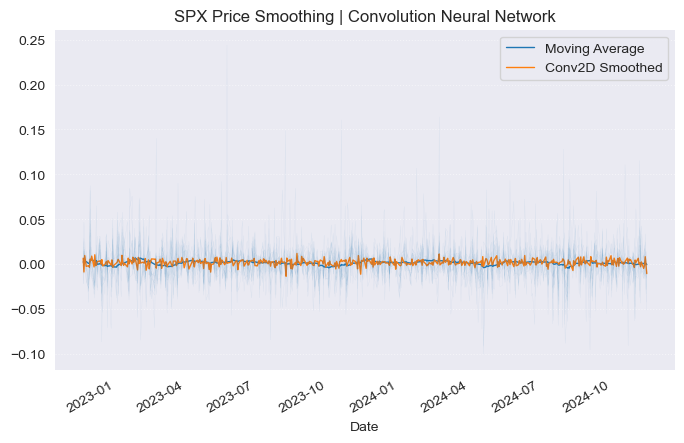

In [23]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(
    data.index[-500:], data.pct_change().mean(axis = 1).rolling(20).mean()[-500:], 
    label = 'Moving Average',
    lw = 1
)
ax.plot(
    data.index[-500:], 
    cnn2d_output[-500:], 
    label = 'Conv2D Smoothed',
    lw = 1
)
plt.legend()
returns.iloc[-500:].plot(ax = ax, legend = False, alpha = 0.1, lw = 0.2, color = 'tab:blue')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('SPX Price Smoothing | Convolution Neural Network')
plt.show()

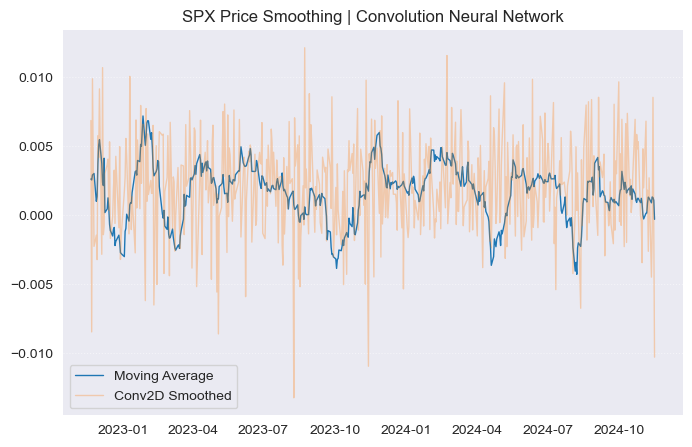

In [25]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(
    data.index[-500:], data.pct_change().mean(axis = 1).rolling(20).mean()[-500:], 
    label = 'Moving Average',
    lw = 1
)
ax.plot(
    data.index[-500:], 
    cnn2d_output[-500:], 
    label = 'Conv2D Smoothed',
    lw = 1,
    alpha = 0.3
)
plt.legend()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('SPX Price Smoothing | Convolution Neural Network')
plt.show()

### Pooling

고차원의 공간 구조를 가진 데이터는 종종 이웃과 유사한 값을 가진 관측치를 초래한다. 이와 같은 특성은 데이터 표현의 중복을 가져오므로 pooling과 같은 데이터 축소 기법을 사용할 필요가 있다. pooling층은 합성곱층에 추가되는 다음과 같은 mapping이다.

$$\bar{R}_{l}^{l+1} : \mathbb{R}^{m_l \times n_l} \rightarrow \mathbb{R}^{m_{l+1} \times n_{l+1}}$$

하나 인기 있는 pooling은 소위 mean pooling $R_{avr}$이다. 이는 다음 형태의 커널 $K$를 사용하는 stride 2 이상의 합성곱이 될 수 있다.

$$K = \frac{1}{9} \begin{pmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{pmatrix}$$

비선형 pooling 연산자 역시 사용된다. 예를 들어 stirde $s$의 $(2k + 1) \times (2k + 1)$ max pooling 연산자는 다음과 같다.

$$\left[ R_{\max}(f)\right]_{i,j} = \max_{-k \leq p, q \leq k} \left\{ f_{s(i-1)+1+p, s(j-1)+1+q}\right\}$$